In [9]:
import PIL
import torch
import torch.nn as nn
import cv2
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

In [6]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()

    MIDLEVEL_FEATURE_SIZE = 128
    resnet=models.resnet18(pretrained=True)
    resnet.conv1.weight=nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    
    self.midlevel_resnet =nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

    

In [10]:
def show_output(grayscale_input, ab_input):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  color_image = torch.cat((grayscale_input, ab_input), 0).detach().numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  # plt.imshow(grayscale_input)
  # plt.imshow(color_image)
  return color_image


In [11]:
def colorize(img_path,print_img=True):
    img=cv2.imread(img_path)
    img=cv2.resize(img,(224,224))
    grayscale_input= torch.Tensor(rgb2gray(img))
    ab_input=model(grayscale_input.unsqueeze(0).unsqueeze(0)).squeeze(0)
    predicted=show_output(grayscale_input.unsqueeze(0), ab_input)
    plt.imshow(predicted)
    return predicted

In [12]:
model=torch.load("model-final.pth").cpu()

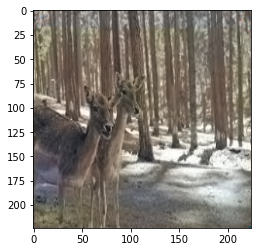

In [13]:
out=colorize(r"Demo Images/download.png")

In [35]:
plt.imsave(r"Demo Images/output.png",out)